# Project CS - Shallow water model

We consider a fluid flowing in one dimension. 

When the fluid deepness of a river or lagoon isn't too big we can consider the fluid is flowing in one dimension, the main direction ($x$ in a 1D model). Starting from the Navier-Stokes equation we can write a reduced model, called **Shallow Water** describing the fluid flow in terms of the fluid heigh $h$ and the flux $q$. The variable $q$ is $uh$ being $u$ the averaged velocity in the $y$ direction, $u(x,t) = { 1 \over h} \int_h u(x,y,t) dy$. 

We have then two variables, depending on time and space, $h = h(x,t)$; $q=q(x,t)$ and we can write the **differential conservation law** of mass and momentum as

$$\dfrac{\partial h}{\partial t} +  \dfrac{\partial q}{\partial x} = 0$$

$$\dfrac{\partial q}{\partial t} +  \partial \dfrac{ (q^2/h + 1/2 g h^2)}{\partial x} = S$$

where $g$ stand by gravity and $S$ is a source term which could model friction, Coriolis forces, surface tension, or the wind over the free surface $h$. The system can be expressed as

$$\dfrac{\partial U}{\partial t} +  \dfrac{\partial F(U)}{\partial x} = S$$

with $F(U)$ the flux and $U = (h,q)^T$ the conserved variables. 

#### Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation
%matplotlib inline

### Finite Differences - MacCormak

Implement the MacCormack method.

This second-order finite difference method was introduced by Robert W. MacCormack in 1969. The MacCormack method is the simplest and elegant approach adapted to hyperbolic equations. This is a predictor-corrector approach, i.e. it predicts in the 1st step an intermediate solution $U_i^{*}$ which is then corrected in a 2nd step. 

The algorithm is

* predictor

$$U_i^{*} = U_i^n - {\Delta t \over \Delta x}  ( F_{i+1}^{n} - F_i^{n} )$$

* corrector

$$U_i^{n+1} = { 1 \over 2} (U_i^n + U_i^{*}) - { 1 \over 2}   {\Delta t \over \Delta x}  ( F_{i}^{*} - F_{i-1}^{*} )$$

The MacCormack algorithm does not introduce diffusive errors but it is known to be dispersive  (Gibbs phenomenon) in high gradient regions.

#### Parameters

In [2]:
# Numerical parameters

# --------------------------------------------------------

# space variables

# number of points to define the mesh
N = 100

# length of the mesh
L = 10.

# Spatial grid
x = np.linspace(0, L, N)
dx = L/(len(x)-1)

# --------------------------------------------------------

# time data

t0 = 0.
T  = 10.

dt = 0.005

# --------------------------------------------------------

# constant
g = 9.81

CFL = dt/dx
CFL

0.0495

##### $\eta$ functions

In [3]:
import scipy.sparse as sp

def eta0_zero(x):            
    
    """  Zero initial height """
    
    eta_0 = np.zeros((len(x)))
    
    return eta_0

def eta0_one(x):            
    
    """  One initial height """
    
    eta_0 = np.ones((len(x)))
    
    return eta_0

def eta0_slope(x):            
    
    """  Smooth slope """
    
    eta_0 = np.zeros((len(x)))
    eta_0 = 1. + .2*x
    
    return eta_0

def eta0_dam(x):    
    
    """  Discontinuous initial condition - dam like shape """
    
    # Data
    L      = x[-1]
    center = L/4
    
    eta_0 = np.zeros((len(x)))
    eta_0 = 1. + 0.2*(x<center)
    
    return eta_0

##### f function

In [4]:
# Different possible bottom

def no_bump(x):
    
    """ No bump function """
    
    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # ---------------------------------------------
    
    # functions
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))

    return (f, df)

def one_bump(x):
    
    """ Elevated bottom function """

    # Initialisation
    f = np.ones((len(x)))
    df = np.zeros((len(x)))
            
    return (f, df)

def gaussian_bump(x, B0, sig, origin):

    """ Gaussian function, equivalent to a bump at the bottom """
    
    # Initialisation
    f  = np.zeros((len(x)))
    df = np.zeros((len(x)))

    # ---------------------------------------------

    # functions
    f  = B0*np.exp(-((x - origin)**2)/(2*sig**2))
    df = (- B0 * (x - origin)/(sig**2)) * np.exp(-((x - origin)**2)/(2*sig**2))
    
    return (f, df)

def slope_bump(x):
    
    """ Rectangular bump function """

    # Initialisation
    f = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # Data
    L     = x[-1] # length mesh
    slope = .05
    
    # ---------------------------------------------
    
    # functions
    f  = slope*x
    df = np.linspace(slope, slope, len(x))
    
    return (f, df)

def beach_bump(x):
    
    """ Beach like bump function """

    # Initialisation
    f = np.zeros((len(x)))
    df = np.zeros((len(x)))
    
    # Data
    L     = x[-1] # length mesh
    slope = .05
    
    # ---------------------------------------------
    
    # functions
    height = 1.5
    om     = np.pi/L # pulsation
    coeff  = 1. # coefficient to reduce inclinasion of bump
    
    f      = height*(1 - coeff*np.cos(om*x))
    df     = -om * coeff*np.sin(om*x)
    
    return (f, df)

##### Flux vector - BC

In [5]:
def fill_F(U, g, eps):
    
    """  Fill Flux vector of equations """
        
    F = np.zeros_like((U))   

    # -------------------------------
    
    idx = (np.abs(U[:,0]) > eps)
    
    # -------------------------------
    
    F[idx,0] = U[idx,1]
    F[idx,1] = U[idx,1]**2/U[idx,0] + (1/2)*g*U[idx,0]**2

    return F

def BC(U):
    
    """  Boundary conditions """
    
    # Height
    U[0,0]  = U[1,0]
    U[-1,0] = U[-2,0]
    
    # Flux
    U[0,1]  = 0 #-U[1,1] #U[1,1]
    U[-1,1] = 0 #-U[-2,1] #U[-2,1] #2*U[-2,1]-U[-3,1]
    
    return U

##### Right hand side member - S

In [6]:
def derivative(f, x):
    
    """ Numerical derivative """
    
    df  = np.zeros((len(x)))
    
    # ------------------------------
    
    # Data
    L  = x[-1]
    dx = L/len(x)
    
    # ------------------------------
    
    df[1:] = (f[1:] - f[:-1])/dx
    df[0]  = df[1]
    
    return df

def S(u, x, f, mu, rho, g, eps):

    """ Shear stress + Topology """

    # Splitting vector
    h = u[:,0]
    q = u[:,1]
    
    # ------------------------------
    
    # Initialisation
    tau = np.zeros((len(h), 2))
    Bx  = np.zeros((len(h), 2))

    # ------------------------------
    
    # indices where not dry
    idx = (np.abs(h) > eps)

    ## S shearing term
    tau[idx,1] = mu*3*q[idx]/h[idx]**2  

    ## S topology term    
    df = derivative(f, x)
    Bx[idx, 1] = g*h[idx]*df[idx]

    return -Bx - tau/rho

#### System solver

In [7]:
# Matrix/Operator version

import scipy.sparse as sp

# --------------------------------------------------------

def diverg_up_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [0, 1], (m, m)).toarray()
    
    Div[0,1]= 0
    Div[0,0] = Div[-1,-1] = 1
   
    return Div

def diverg_down_op(m):
    
    """ divergence operator """
    
    Div = sp.diags([-1, 1], [-1, 0], (m, m)).toarray()
    
    Div[-1,-2]= 1
    
    return Div
    
    
## Algo

def q_MC(x, dx, t0, T, dt, u_ini, f, g, rho, mu, eps):

    """  The MacCormak method """
    
    u      = u_ini.copy();
    BC(u)
    
    h      = [u[:,0].copy()] # h variable
    q      = [u[:,1].copy()] # q variable
    
    # -------------------------------------------
    
    Div_down = diverg_down_op(len(u[:,0]))
    Div_up   = diverg_up_op(len(u[:,0]))
    
    # -------------------------------------------
    
    npas = int(T/dt)
    t      = t0
    i      = 0
    
    while i < npas:
        
        i += 1
        t += dt    
            
        # predictor solution
        F      = fill_F(u, g, eps)
        u_star = u - (dt/dx)*Div_up@F + dt*S(u, x, f, mu, rho, g, eps)
        
        # BCs:
        BC(u_star)
        
        # ------------------------------------------------------------------------------------------------
                       
        # corrector solution
        F_star = fill_F(u_star, g, eps)
        unew   = .5*(u+u_star) - .5*(dt/dx)*Div_down@F_star + dt*S(u_star, x, f, mu, rho, g, eps)
        
        # BCs:
        BC(unew)
        
        if (i%30)==0: #We only take some values (every a in i%a)
            h.append(unew[:,0].copy()) # vector containing h(x,T) for each iteration
            q.append(unew[:,1].copy()) # vector containing h(x,T) for each iteration
        
        u = unew.copy()         # vector containing u(x,T)
    
    return (h, q, t)

##### Initialisation

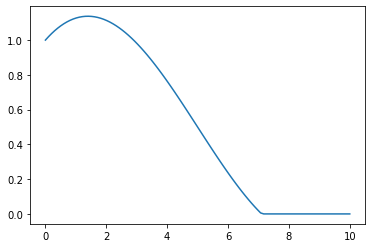

In [8]:
## Chose bottom

# Data bump

# Length
L      = x[-1]

# Height
B0     = 5.5

# Width
sig    = .5

# Origin
origin = L/2

(B, Bx) = beach_bump(x)

# --------------------------------------------

## Chose initial state

# Initial eta
eta0 = eta0_slope(x).reshape(-1,1)
f    = B.reshape(-1,1)

# Initial height
h0   = (eta0 - f)*(eta0>f)

# Initial flux
q0   = np.zeros((len(x)))
q0   = q0.reshape(-1, 1)

# Concatenation
u_ini = np.append(h0, q0, axis=1)

# --------------------------------------------

## Checking
plt.plot(x, h0)

##### Function to avoid movement when height must remain constant - Rest Lake ??

In [9]:
def rest_lake(k0):
    
    h = np.abs(max(k0) - min(k0))

    if h==0:
        return False # no rest lake
    else:
        return True # There is rest lake

#### Solving dry state

In [10]:
# Data
mu  = 10**-3
rho = 10**3 #[kg.m-3] water volumic mass

# Time of study
T   = 20.

# Precision over height
eps = 8*10**-2

# -----------------------------------------------------------------

if rest_lake(eta0)==True: # i.e. if ther is rest lake ## function to check whether height is const or not ## arr.tolist() == from array to list
    (h, q, t_final) = q_MC(x, dx, t0, T, dt, u_ini, B, g, rho, mu, eps)
    
    print('\nWe check for stability')
    print('At final time t = {:.0f} s\n'.format(t_final))
    print('H_final(x=L) = {:.5f} \n'.format(h[-1][-1]))
    print('Q_final(x=L) = q(x, {:.0f}) = {:.2f}'.format(t_final, q[-1][-1]))

else:
    h = (eta0 - f)*(eta0>f)
    q  = u_ini[:,1].tolist()

    B = B.reshape(-1,1)

    print('\nWe check for stability')
    print('At final time t = {:.0f} s\n'.format(T))
    print('H_final(x=L) = {:.5f} \n'.format(h[-1][-1]))
    print('Q_final(x=L) = q(x, {:.0f}) = {:.2f}'.format(T, q[-1]))

# Speed
u = np.array(q)/np.array(h)


We check for stability
At final time t = 20 s

H_final(x=L) = -0.00000 

Q_final(x=L) = q(x, 20) = 0.00


<ipython-input-10-6c4ca078a395>:33: RuntimeWarning: invalid value encountered in true_divide
  u = np.array(q)/np.array(h)


#### Animation - Smooth IC

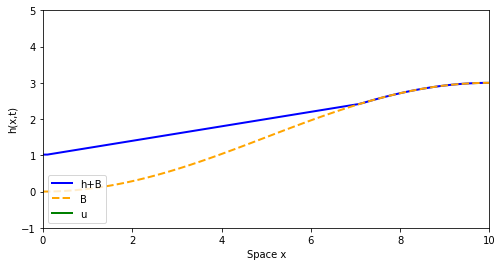

In [11]:
import matplotlib.animation as animation
from IPython.display import HTML

#%matplotlib notebook

n = np.arange(0, np.shape(h)[0]) 

fig   = plt.figure(figsize=(8,4))    # Create an empty figure
ax    = plt.axes()

line1, = ax.plot([], [], 'b-', linewidth=2)  # Line plot for h
line2, = ax.plot([], [], '--', color='orange', linewidth=2)  # Line plot for B
line3, = ax.plot([], [], 'g-', linewidth=2)  # Line plot for u

plt.xlabel('Space x')
plt.ylabel('h(x,t)')

plt.axis((0, 10, -1, 5))              # Set the bounds of the plot

def plot_q(n):
    line1.set_data(x, (h+B)[n])
    line2.set_data(x, B)
    #line3.set_data(x, u[n])

    return[line1, line2, line3]
    
anim = animation.FuncAnimation(fig, plot_q, frames=n)  # Animate the solution

plt.legend(['h+B', 'B', 'u'], loc=3)

#plt.show()
HTML(anim.to_jshtml())